# Compare gridMET data and modeled input

### What this notebook does: 
- Compare the 2015 gridMET data pulled at TE locations (using TE_fetcher_parser_nearest_neighbor_Daily_gridMET_data) to 2015 input data from Harris and Diehl (2019)

### Why the comparison/ big picture goal: 
- Develop bias correction for gridMET data. Since 2015 input data from Harris and Diehl (2019) involved a lot of QA/QC and used climate stations, we will capitalize on that knowledge to better understand where the gridMET data might have issues. 

### Environment -- use 'ofp_for_te_.yml' 

In [1]:
# step 0- import the needed packages
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import geopandas as gpd
import pandas as pd
import os
import numpy as np
from shapely.geometry import Point, polygon
from matplotlib.backends.backend_pdf import PdfPages

Populating the interactive namespace from numpy and matplotlib


In [2]:
# step 1- bring in df with lat longs of TE plants, gridMET data, 2015 model input data
TEdir = r'C:\WBEEP\Thermoelectric-master\Climate_data_fetcher'
TE_shp = gpd.read_file(os.path.join(TEdir, '..\GIS','2015_TE_Model_Estimates_lat.long_COMIDs.shp'))
GM_data = pd.read_csv(os.path.join(TEdir, 'TE_plants_w_2015_daily_gridMET.csv'))
input_2015 = pd.read_csv(os.path.join(TEdir, '..\TE_Harris_Diehl_2015', '2015_TE_input_data_AEG.csv'))
# Combined longterm pond net evap2.xlsx with 2015 input data

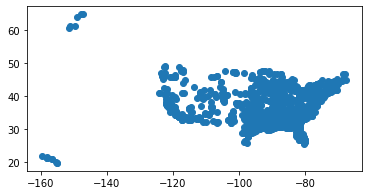

In [33]:
TE_shp.plot()

In [3]:
# step 2- alter format of input_2015 for easier comparison to GM_data

# remove duplicate plant EIAs and names, the duplicates are for different system types at the same location
# but not relevant for comparing climate data.Remove columns relating to CD and WT- don't have those variables to compare to
input_2015.drop_duplicates(subset = 'EIA_PLANT_ID', inplace=True)
input_2015.drop(columns = ['COUNTY', 'STATE', 'NAME_OF_WATER_SOURCE','COOLING_TYPE', 'MODEL_TYPE', 'PERCENT_CD_ALLOCATION', 
                        'ELEVATION','POND_AREA','CD_Jan', 'CD_Feb', 'CD_Mar', 'CD_Apr', 'CD_May', 'CD_Jun', 'CD_Jul', 'CD_Aug',
                       'CD_Sep', 'CD_Oct', 'CD_Nov', 'CD_Dec','WT_Jan', 'WT_Feb', 'WT_Mar', 'WT_Apr', 'WT_May', 'WT_Jun', 'WT_Jul',
                       'WT_Aug', 'WT_Sep', 'WT_Oct', 'WT_Nov', 'WT_Dec'], inplace=True)

    

In [4]:
# step 2.1 a little more data manipulation, make rows into columns basically.
plants = input_2015['EIA_PLANT_ID']
cols = ['DB','WB','WS','EV']

for i, EIA in enumerate(plants):
    temp = input_2015[input_2015['EIA_PLANT_ID'] == EIA]
    DB = temp.loc[:, 'DB_01':'DB_12']
    WB = temp.loc[:, 'WB_01':'WB_12']
    WS = temp.loc[:, 'WS_01':'WS_12']
    EV = temp.loc[:, 'EV_01':'EV_12']
    variables = [DB,WB,WS,EV]
    
    for j, var in enumerate(variables):
        df = var.T.reset_index()        
        df['index'] = df['index'].str[-2:]
        df.columns = ['MONTH', cols[j]]
        if j == 0:
            df1 = df.copy(deep=True)
        else: 
            df1 = pd.merge(df1, df, on = 'MONTH')
    
    df1['EIA_PLANT_'] =  EIA
    
    if i == 0:
        df2 = df1.copy(deep=True)
    else:
        df2 = df2.append(df1)


In [5]:
# step 2.2 a little more data manipulation, ordering of columns, unit conv
conv_mm=25.4 #inches to mm
conv_ms = 1/60/60*1609.34
#reorder columns
p_mod_input =df2.copy(deep=True)
p_mod_input = p_mod_input[['EIA_PLANT_','MONTH','DB', 'WB', 'WS', 'EV']]
#conv Evap from inches to mm
p_mod_input['EV'] = p_mod_input['EV']*conv_mm
#conv WS from mph to m/s
p_mod_input['WS'] = p_mod_input['WS']*conv_ms

#rename cols
cols = ['EIA_PLANT_','MONTH','DB_C', 'WB_C', 'WS_ms','EV_mm']
p_mod_input.columns = cols

In [6]:
# Step 3- calculate monthly means and medians from gridMET data
GM_data['YEAR'] = GM_data['day'].astype(str).str[0:4]
GM_data['MONTH'] = GM_data['day'].astype(str).str[5:7]

In [7]:
GM_data.drop(columns = ['Unnamed: 0'], inplace=True) # also drops HI and AK plants, no gridMET data there to compare, so 1106 
#plants instead of 1122

In [9]:
# Step 3- calculate monthly means and medians from gridMET data
#GM_data['YEAR'] = GM_data['day'].astype(str).str[0:4]
#GM_data['MONTH'] = GM_data['day'].astype(str).str[5:7]

month_means = pd.pivot_table(GM_data, index = ['EIA_PLANT_','MONTH'], aggfunc=np.mean)
month_medians = pd.pivot_table(GM_data, index = ['EIA_PLANT_','MONTH'], aggfunc=np.median)
month_means.reset_index(inplace=True)
month_medians.reset_index(inplace=True)
#GM_data.drop(columns = ['Unnamed: 0'], inplace=True) ##not sure why I cant do this before the aggfunc, but if I do
# the number of plants reduces to 1106. Maybe there are some plants that are getting aggregated wrong. for now this is the 
# work aroudn to drop that column after


In [10]:
month_means.head()

,EIA_PLANT_,MONTH,air_tmp_C_avg,open_wtr_et_mm,wb_tmp_C,wnd_spd_m_s
0,3,01,8.361297,2.259193,4.988474,4.051613
1,3,02,7.560718,2.512500,4.207253,4.464286
2,3,03,16.924196,3.553064,12.954469,3.890323
3,3,04,20.540006,4.396000,16.756763,3.776667
4,3,05,23.209678,5.510806,19.329525,3.254839


In [11]:
# Adding a column called "EIA_P_DATE" which combines EIA PLANT and DATE 
month_means['EIA_P_DATE'] = month_means.apply(lambda row: str(row.EIA_PLANT_) + "_2015-" + str(row.MONTH), axis = 1)
month_medians['EIA_P_DATE'] = month_medians.apply(lambda row: str(row.EIA_PLANT_) + "_2015-" + str(row.MONTH), axis = 1)
p_mod_input['EIA_P_DATE'] = p_mod_input.apply(lambda row: str(row.EIA_PLANT_) + "_2015-" + str(row.MONTH), axis = 1)


In [12]:
month_means.shape

(13272, 7)

In [13]:
13272/1106

12.0

In [14]:
#rename cols
cols_mean =['EIA_PLANT_','MONTH','gm_DB_mean', 'gm_EV_mean', 'gm_WB_mean','gm_WS_mean','EIA_P_DATE']
month_means.columns = cols_mean
cols_median =['EIA_PLANT_','MONTH','gm_DB_med', 'gm_EV_med', 'gm_WB_med','gm_WS_med','EIA_P_DATE']
month_medians.columns = cols_median

#reorder cols
month_means = month_means[['EIA_P_DATE','EIA_PLANT_','MONTH','gm_DB_mean', 'gm_WB_mean', 'gm_WS_mean', 'gm_EV_mean']]
month_medians = month_medians[['EIA_P_DATE','EIA_PLANT_','MONTH','gm_DB_med', 'gm_WB_med', 'gm_WS_med', 'gm_EV_med']]
p_mod_input = p_mod_input[['EIA_P_DATE','EIA_PLANT_','MONTH', 'DB_C','WB_C','WS_ms','EV_mm']]


In [16]:
len(month_means) == 1106*12
len(month_medians) == 1106*12


True

In [17]:
#merge the dfs on EIA_P_DATE
mean_stats = pd.merge(month_means, p_mod_input, on = 'EIA_P_DATE')

In [18]:
# Calculate the RMSE between monthly values
# future- use sklearn mean_squared_error, for now not messing with the env, just using numpy
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

In [19]:
mean_stats.head()

,EIA_P_DATE,EIA_PLANT__x,MONTH_x,gm_DB_mean,gm_WB_mean,gm_WS_mean,gm_EV_mean,EIA_PLANT__y,MONTH_y,DB_C,WB_C,WS_ms,EV_mm
0,3_2015-01,3,01,8.361297,4.988474,4.051613,2.259193,3,01,7.1,9.7,3.442199,NaN
1,3_2015-02,3,02,7.560718,4.207253,4.464286,2.512500,3,02,6.5,9.1,3.889238,NaN
2,3_2015-03,3,03,16.924196,12.954469,3.890323,3.553064,3,03,15.3,18.0,3.218680,NaN
3,3_2015-04,3,04,20.540006,16.756763,3.776667,4.396000,3,04,19.1,21.5,2.950457,NaN
4,3_2015-05,3,05,23.209678,19.329525,3.254839,5.510806,3,05,20.8,24.0,2.861049,NaN


In [20]:
# calculate the rmse between predictions (gridMET data) and targets (climate station corrected data). Maybe there is a better 
# vectorized way to do this, takes a few mins
for i in range(len(mean_stats)):
    mean_stats.loc[i, 'RMSE_DB'] = rmse(mean_stats.loc[i,'gm_DB_mean'], mean_stats.loc[i,'DB_C'])
    mean_stats.loc[i, 'RMSE_WB'] = rmse(mean_stats.loc[i,'gm_WB_mean'], mean_stats.loc[i,'WB_C'])
    mean_stats.loc[i, 'RMSE_WS'] = rmse(mean_stats.loc[i,'gm_WS_mean'], mean_stats.loc[i,'WS_ms'])
    mean_stats.loc[i, 'RMSE_EV'] = rmse(mean_stats.loc[i,'gm_EV_mean'], mean_stats.loc[i,'EV_mm'])


In [100]:
#compute the obs-sim column
mean_stats['OBS_SIM_DB'] = mean_stats['DB_C'] - mean_stats['gm_DB_mean']
mean_stats['OBS_SIM_WB'] = mean_stats['WB_C'] - mean_stats['gm_WB_mean']
mean_stats['OBS_SIM_WS'] = mean_stats['WS_ms'] - mean_stats['gm_WS_mean']
mean_stats['OBS_SIM_EV'] = mean_stats['EV_mm'] - mean_stats['gm_EV_mean']

In [24]:
# fix up the df 
mean_stats.drop(columns= ['EIA_PLANT__y', 'MONTH_y'], inplace = True)

In [102]:
mean_stats.columns

Index(['EIA_P_DATE', 'EIA_PLANT_', 'MONTH', 'gm_DB_mean', 'gm_WB_mean',
       'gm_WS_mean', 'gm_EV_mean', 'DB_C', 'WB_C', 'WS_ms', 'EV_mm', 'RMSE_DB',
       'RMSE_WB', 'RMSE_WS', 'RMSE_EV', 'OBS_SIM_DB', 'OBS_SIM_WB',
       'OBS_SIM_WS', 'OBS_SIM_EV'],
      dtype='object')

In [104]:
cols = ['EIA_P_DATE', 'EIA_PLANT_', 'MONTH', 'gm_DB_mean', 'gm_WB_mean',
       'gm_WS_mean', 'gm_EV_mean', 'DB_C', 'WB_C',
       'WS_ms', 'EV_mm', 'RMSE_DB', 'RMSE_WB', 'RMSE_WS', 'RMSE_EV', 'OBS_SIM_DB', 'OBS_SIM_WB',
       'OBS_SIM_WS', 'OBS_SIM_EV']
mean_stats.columns = cols

In [105]:
# and add lat long for plotting
mean_plot = pd.merge(mean_stats, TE_shp, on = 'EIA_PLANT_')

In [106]:
mean_plot.drop(columns = ['NAME_OF_WA','COMID', 'COOLING_TY','GENERATION', 'WATER_SOUR', 'WATER_TYPE', 
                         'WITHDRAWAL', 'CONSUMPTIO','MIN_WITHDR', 'MAX_WITHDR', 'MIN_CONSUM', 'MAX_CONSUM', 
                         'NET_GENERA','geometry'], inplace =True)

SyntaxError: can't assign to operator (<ipython-input-111-b70182a09ddf>, line 3)

In [109]:
months

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

In [99]:
mean_plot_jan.head()

,EIA_P_DATE,EIA_PLANT_,MONTH,gm_DB_mean,gm_WB_mean,gm_WS_mean,gm_EV_mean,DB_C,WB_C,WS_ms,...,RMSE_DB,RMSE_WB,RMSE_WS,RMSE_EV,OBS_SIM_DB,PLANT_NAME,COUNTY,STATE,LATITUDE,LONGITUDE
0,3_2015-01,3,01,8.361297,4.988474,4.051613,2.259193,7.1,9.7,3.442199,...,1.261297,4.711526,0.609414,NaN,-1.261297,Barry,Mobile,AL,31.006964,-88.010900
12,7_2015-01,7,01,5.254847,1.955339,4.009677,1.883226,2.8,5.4,2.503418,...,2.454847,3.444661,1.506260,NaN,-2.454847,Gadsden,Etowah,AL,34.013611,-85.970278
24,8_2015-01,8,01,5.045168,1.943996,4.129032,1.930645,3.3,6.1,2.637529,...,1.745168,4.156004,1.491503,NaN,-1.745168,Gorgas,Walker,AL,33.644694,-87.199743
36,10_2015-01,10,01,6.306458,3.151530,3.793548,1.954355,4.4,7.2,2.637529,...,1.906458,4.048470,1.156019,NaN,-1.906458,Greene County,Greene,AL,32.601935,-87.782006
48,26_2015-01,26,01,6.219356,2.932816,4.161290,2.052581,3.5,6.3,2.458714,...,2.719356,3.367184,1.702576,NaN,-2.719356,E C Gaston,Shelby,AL,33.244058,-86.457463


In [40]:
geometry = [Point(xy) for xy in zip(mean_plot_jan['LONGITUDE'],mean_plot_jan['LATITUDE'])]
geometry[:3]



In [43]:
crs = {'init': 'epsg:4326'}

In [46]:
jan_df = gpd.GeoDataFrame(mean_plot_jan, crs = crs, geometry= geometry)

In [53]:
mn = np.min(jan_df['RMSE_DB'])
mx = np.max(jan_df['RMSE_DB'])

mx

10.816136438709677

In [ ]:
for_plot = for_plot.fillna(-999)

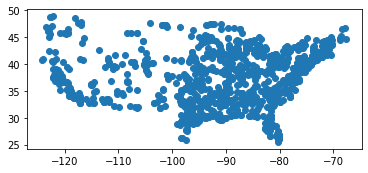

In [61]:
jan_df.plot()

In [ ]:
months = ['01','02','03','04', '05', '06', '07', '08', '09', '10', '11', '12']
for i, val in enumerate(months):
    monthly_df = mean_plot[mean_plot['MONTH']==val]

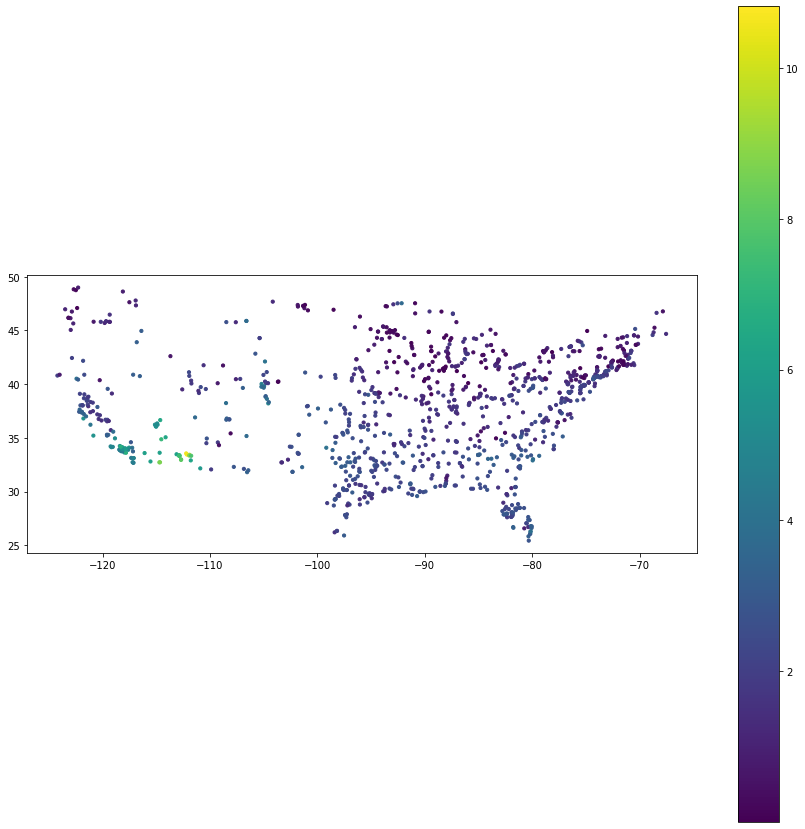

In [74]:
fig, ax = plt.subplots(figsize = (15,15))
jan_df.plot(column = 'RMSE_DB', ax = ax, legend=True, markersize=10)


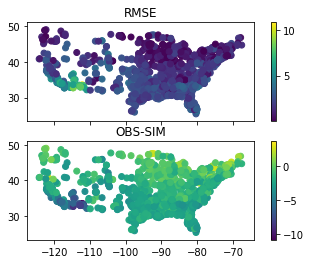

In [94]:
with PdfPages('January.pdf') as pdf:

    for i, val in enumerate()
    fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True, sharey= True)
    ax1.set_title('RMSE')
    jan_df.plot(ax = ax1, column = 'RMSE_DB', legend = True)
    ax2.set_title('OBS-SIM')
    jan_df.plot(ax = ax2, column = 'OBS_SIM', legend = True)

    pdf.savefig()

(array([  2.,   7.,   9.,  28.,  41., 362., 457., 172.,  23.,   5.]),
 array([-10.81613644,  -9.36855538,  -7.92097432,  -6.47339326,
         -5.02581221,  -3.57823115,  -2.13065009,  -0.68306903,
          0.76451203,   2.21209308,   3.65967414]),
 <a list of 10 Patch objects>)

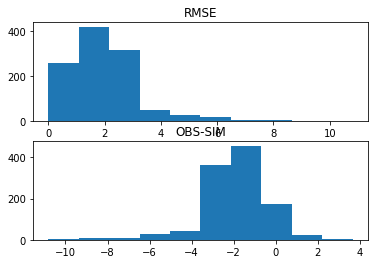

In [91]:
fig, (ax1, ax2) = plt.subplots(nrows = 2)
ax1.set_title('RMSE')
ax1.hist(jan_df['RMSE_DB'])
ax2.set_title('OBS-SIM')
ax2.hist(jan_df['OBS_SIM'])


In [ ]:
for_plot_jan.to_csv('RMSE_Jan.csv')

In [ ]:
for_plot_feb = for_plot[for_plot['MONTH']=='02']

In [ ]:
for_plot_jan.to_csv('RMSE_Jan.csv')

In [ ]:
range_pm = np.max(for_plot_jan['DB_C'])-np.min(for_plot_jan['DB_C'])
range_gm = np.max(for_plot_jan['gm_DB_mean'])-np.min(for_plot_jan['gm_DB_mean'])

In [ ]:
range_gm

In [ ]:
# Identify and analyze these fits. Are the trends regional? correlations with elevation? 

In [ ]:
# Calculate a bias correction for the gridMET data
# underlying assumption is that the 2015 input data is "true". Any caveats here? Although 2015 input data was rigorously
# examined, there are more temporal data with gridMET, for which there might be some value. 